In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from google.colab import files

fileupload = files.upload()
data = pd.read_csv(BytesIO(fileupload['HR_comma_sep.csv']))
data.head()

Saving HR_comma_sep.csv to HR_comma_sep (2).csv


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
print('Size of Data: {}\n'.format(data.shape))
print('Number of Classes for Department: \n{}\n'.format(data.Department.value_counts()))
print('Number of Classes for Salary: \n{}'.format(data.salary.value_counts()))

Size of Data: (14999, 10)

Number of Classes for Department: 
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: Department, dtype: int64

Number of Classes for Salary: 
low       7316
medium    6446
high      1237
Name: salary, dtype: int64


In [3]:
# Transforming the columns that are categorical in nature
from sklearn.preprocessing import LabelEncoder

# Use One-Hot Coding to transform the Department feature
data_department = pd.get_dummies(data['Department'], prefix = 'Department')

# Concatenate the transformed features into the original data
data1 = pd.concat([data,data_department], axis = 1)

# Deleting the original Department feature
data1 = data1.drop(['Department'], axis = 1)

# Use Label Encoding to transform the salary feature
le = LabelEncoder()
data1['salary'] = le.fit_transform(data1['salary'])

print(data1.columns)

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'salary', 'Department_IT', 'Department_RandD',
       'Department_accounting', 'Department_hr', 'Department_management',
       'Department_marketing', 'Department_product_mng', 'Department_sales',
       'Department_support', 'Department_technical'],
      dtype='object')


In [4]:
# Extract out the features
X = data1.drop(['left'], axis = 1).values

# Extract out the target
y = data1['left'].values

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Generating random noise data to test if model is able to discern
rng = np.random.RandomState(0)
noisedata = rng.normal(size = (len(X),9))
print('Size of Noise Data Generated: {}'.format(noisedata.shape))

# Adding noise data to the features data X
X_w_noise = np.hstack([X, noisedata])
print('Size Data After Combining: {}'.format(X_w_noise.shape))

# Splitting data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, y, random_state = 0, test_size = 0.3)

# Feature scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Size of Noise Data Generated: (14999, 9)
Size Data After Combining: (14999, 27)


Features Selected: 
[ True False False  True  True  True  True False False False False False
 False False False False False False False False False False False False
 False False False]



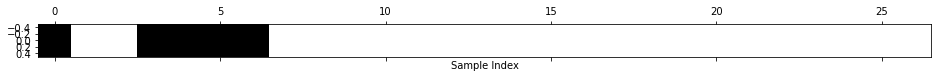

In [6]:
# Univariate Statistics Feature Selection

from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LogisticRegression

# Determine the number of features to retain
select = SelectPercentile(percentile = 17)
select.fit(X_train_scaled, y_train)

mask = select.get_support()
print('Features Selected: \n{}\n'.format(mask))

# Visualize the mask - black is True and white is False
plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')
plt.xlabel('Sample Index')

# Features dataset after transformation
X_train_us = select.transform(X_train_scaled)
X_test_us = select.transform(X_test_scaled)

Features Selected: 
[ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False]



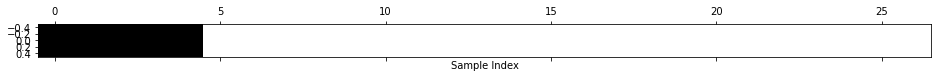

In [7]:
# Model-Based Feature Selection

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Feature selection from model
select1 = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 0), max_features = 5)
select1.fit(X_train_scaled, y_train)

mask = select1.get_support()
print('Features Selected: \n{}\n'.format(mask))

# Visualize the mask - black is True and white is False
plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')
plt.xlabel('Sample Index')

# Features dataset after transformation
X_train_l1 = select1.transform(X_train_scaled)
X_test_l1 = select1.transform(X_test_scaled)

Features Selected: 
[ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False]



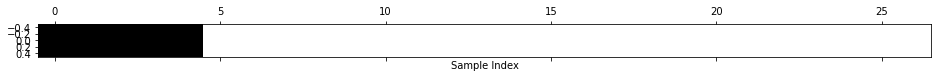

In [8]:
# Interative Feature Selection using Recursive Feature Elimination

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Feature selection by RFE
select2 = RFE(RandomForestClassifier(n_estimators = 100, random_state = 0), n_features_to_select = 5)
select2.fit(X_train_scaled, y_train)

mask = select2.get_support()
print('Features Selected: \n{}\n'.format(mask))

# Visualize the mask - black is True and white is False
plt.matshow(mask.reshape(1, -1), cmap = 'gray_r')
plt.xlabel('Sample Index')

# Features dataset after transformation
X_train_rfe = select2.transform(X_train_scaled)
X_test_rfe = select2.transform(X_test_scaled)

In [9]:
# Without Selection of Features & Noise Data

from sklearn.preprocessing import MinMaxScaler

# Data with 18 features (after encoding)
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(X, y, random_state = 0, test_size = 0.3)

# Scaling of data
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train_ori)
X_test_s = scaler.transform(X_test_ori)

# Fitting of scaled features to model
lr = LogisticRegression()
lr.fit(X_train_s, y_train_ori)

print('Test Score Without Feature Selection: {:.2f}'.format(lr.score(X_test_s, y_test_ori)))

Test Score Without Feature Selection: 0.77


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Defining pipeline
pipe = Pipeline([('preprocessing',MinMaxScaler()), ('classifier',LogisticRegression())])

# Finding the best parameters for model
param_grid = {'classifier__C':[0.01,0.02,0.05,0.1,1,10,100]}

# GridSearch and Cross-Validate to obtain best parameters
grid = GridSearchCV(pipe, param_grid, cv = 10)

# Fitting of features to model from RFE method
grid.fit(X_train_rfe, y_train)

print('Test Score for Univariate Statistics: {:.2f}'.format(grid.fit(X_train_us, y_train).score(X_test_us, y_test)))
print('Test Score for Model Based Selection: {:.2f}'.format(grid.fit(X_train_l1, y_train).score(X_test_l1, y_test)))
print('Best Cross-Validation Score for Iterative Feature Selection: {:.2f}'.format(grid.best_score_))
print('Test Score for Iterative Feature Selection: {:.2f}'.format(grid.score(X_test_rfe, y_test)))

Test Score for Univariate Statistics: 0.82
Test Score for Model Based Selection: 0.80
Best Cross-Validation Score for Iterative Feature Selection: 0.80
Test Score for Iterative Feature Selection: 0.80


In [ ]:
!pip install mglearn
import mglearn

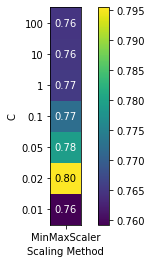

In [12]:
# Dataframing results obtained from RFE fit 
results = pd.DataFrame(grid.cv_results_)

# Plotting of heat map chart for different combination of parameters
score = np.array(results.mean_test_score).reshape(7,1)
score_img = mglearn.tools.heatmap(score, xlabel = 'Scaling Method', xticklabels = ['MinMaxScaler'], ylabel = 'C', yticklabels = param_grid['classifier__C'], cmap = "viridis")
plt.colorbar(score_img)